# <center>K-means ++</center>



```
K-means nos permite la agrupación de un conjunto de entrada en diversos subgrupos que cuentan con características similares.
K-means ++ es una técnica inteligente de inicialización del centroide.
```



**Algoritmo K-Means++**
1. Tomar un centroide $c_1$, elegido uniformemente al azar de $X$.
2. Tomar un nuevo centroide $c_i$, eligiendo $x \in X$ con probabilidad  $\frac{D(x)^2}{\sum_{x \in X} D(x)^2}$.
3. Repetir el paso \textbf{2}. hasta tener todos los $K$ centroides.
4. Proceder con el algoritmo del K-means estándar.

  
  

## Library import

In [1]:
import random
import statistics
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.stats import mannwhitneyu
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from itertools import permutations 

import warnings
warnings.filterwarnings("ignore")

## Data import

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Data exploration

In [3]:
df = pd.read_csv(r'C:\Users\Artemio\Documents\Python\Machile Learning\dataset\Mall_Customers.csv')
print('Dimension del dataset: ', df.shape)
df.head()

Dimension del dataset:  (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Comprobar que no hay valores NaN
df.isna().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
# Descripción del dataset
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
X = df.iloc[:, [3, 4]].values
y = df.iloc[:,-1:].values
print('Num de datos: ', X.shape[0])
print('Num de columnas: ', X.shape[1])

Num de datos:  200
Num de columnas:  2


## Data visualization

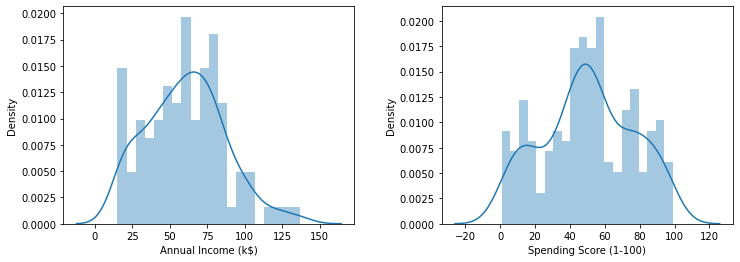

In [ ]:
# Distribución de los atributos
atributos = ['Annual Income (k$)', "Spending Score (1-100)"]
aux = 1 

plt.figure(1 , figsize = (12 , 4))
for i in atributos:
    plt.subplot(1, 2, aux)
    plt.subplots_adjust(wspace = 0.3)
    sns.distplot(df[i], bins=20, kde = True)
    aux += 1
plt.show()

In [ ]:
# # Balance de las clases
# plt.figure(figsize=(5,3))
# g = sns.countplot(x=df['CustomerType'])
# plt.show()

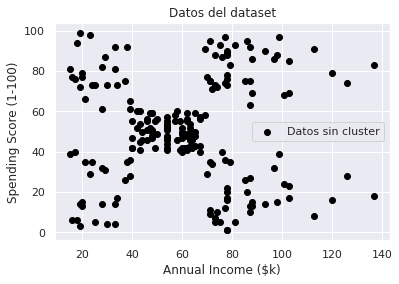

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(X[:,0],X[:,1],c='black',label='Datos sin cluster')
plt.xlabel('Annual Income ($k)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.title('Datos del dataset')
plt.show()

# Creacion del Kmeans ++

In [ ]:
class Kmeans_pp:
    # Inicializacion--------------------------------------------------------------
    def __init__(self,X,K):
        self.X = X                #Datos de entrada
        self.Output = {}          #Diccionario para un manejo más visual
        self.Centroides = np.array([]).reshape(self.X.shape[1],0) #Centroides
        self.K = K                # K clusters
        self.m = self.X.shape[0]  #
    #-----------------------------------------------------------------------------

    # K-means ++ -----------------------------------------------------------------
    def kmeanspp(self, X, K):
        # Paso 1. Selecciono aleatoriamente el primer centroide de los de datos y 
        # lo añado a la matriz de centroides. 
        i = random.randint(0, X.shape[0]-1)
        C = np.array([X[i]])
        # Paso 2. Calculo la distancia euclidiana desde los centroides ya elegidos,
        # añado la distancia mínima a una matriz Distancia (D).
        for k in range(1, K):
            D = np.array([]) 
            for x in X:
                D = np.append(D, np.min(np.sum((x-C)**2)))
        # Paso 3. Calculo las probabilidades de elegir el punto como el próximo 
        # centroide dividiendo la matriz D con la suma de la matriz D.
            prob = D/np.sum(D)
        # Paso 4. Calculo la distribución de probabilidad acumulada. 
            cummulative_prob = np.cumsum(prob)
        # Paso 5. Selecciono un número random, si el index es mayor lo asigno 
            r = random.random()
            i = 0
            for j,p in enumerate(cummulative_prob):
                if r < p:
                    i = j
                    break
            C = np.append(C, [X[i]], axis=0)
        return C.T
    #-----------------------------------------------------------------------------

    # Entrenamiento --------------------------------------------------------------
    def fit(self,max_iter):
    # Inicializo los centroides
        self.Centroides = self.kmeanspp(self.X, self.K) 
        # Calculo de distancias Euclidianas y hago la asignación de Clusters
        for n in range(max_iter):
            Dist_Euclidiana = np.array([]).reshape(self.m,0)
            for k in range(self.K):
                d = np.sum((self.X-self.Centroides[:,k])**2,axis=1)
                Dist_Euclidiana = np.c_[Dist_Euclidiana, d]
            C = np.argmin(Dist_Euclidiana, axis=1)+1
            # Reajuste de centroides
            O = {}
            for k in range(self.K):
                O[k+1] = np.array([]).reshape(2,0)
            for i in range(self.m):
                O[C[i]] = np.c_[O[C[i]],self.X[i]]    
            for k in range(self.K):
                O[k+1] = O[k+1].T
            for k in range(self.K):
                self.Centroides[:,k]=np.mean(O[k+1],axis=0)  
            self.Output = O  
    #-----------------------------------------------------------------------------

    # Prediccion -----------------------------------------------------------------
    def predict(self):
        return self.Output, self.Centroides.T
    #-----------------------------------------------------------------------------

In [ ]:
def Visualizacion(Output, Centroides):   
    color=['deepskyblue','forestgreen','deeppink','red','indigo']
    labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
    plt.figure(figsize=(8,5))

    for k in range(K):
        plt.scatter(Output[k+1][:,0], Output[k+1][:,1], c=color[k], label=labels[k])

    plt.scatter(Centroides[:,0], Centroides[:,1], s=150, c='yellow', marker='o', label='Centroides')
    plt.title('K-means ++')
    plt.xlabel('Annual Income ($K)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()
    plt.show()

In [ ]:
def get_accuracy(y, predictions):
    allPermutations=np.array(list(permutations(np.unique(y))))
    acc=[]
    for perm in allPermutations:
        classes=np.arange(0,y.shape[0])
        for index in range(classes.shape[0]):
            classes[index]=np.where(y[index]==perm)[0][0]
        acc.append(np.sum(classes==predictions))
    acc=np.array(acc)
    bestAccIndex=np.where(max(acc)==acc)[0][0]
    return dict(zip(np.arange(0,allPermutations.shape[1]),allPermutations[bestAccIndex])), acc[bestAccIndex]

## Método Elbow



```
El método Elbow se utiliza para determinar el número óptimo de clusters en el algoritmo k-means / k-means ++.
```


* Traza el valor de la función de costo producida por diferentes valores de k.
* Se elige un # de clusters tal que la adición de otro cluster no proporcione un modelado mucho mejor de los datos. 
* Se usó la WSS como función de costo para identificar la suma de las distancias cuadradas de las muestras al centro del cluster más cercano.


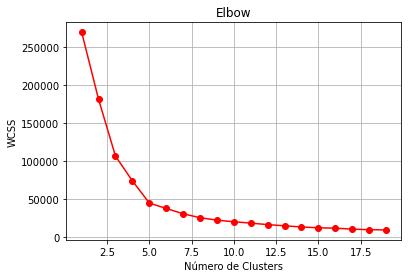

In [ ]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss, 'ro-')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Elbow')
plt.grid()
plt.show()



```
El codo se puede encontrar, aproximadamente, donde el número de clusters es igual a 5. 
Por lo tanto, K = 5.
```

***

# K-means ++ no supervisado

## Propio

In [ ]:
# Número de Clusters
K = 5
# Criterio de paro
max_iter = 50

In [ ]:
# K-means con el dataset completo
kmeans = Kmeans_pp(X,K)
kmeans.fit(max_iter)
Output, Centroides = kmeans.predict()

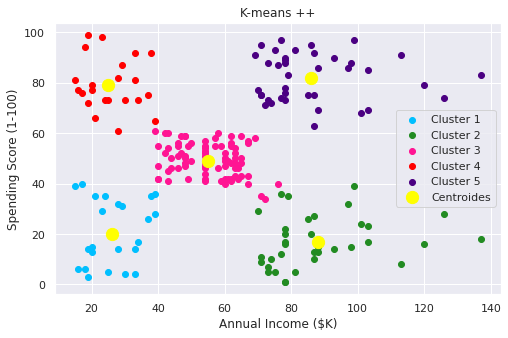

In [ ]:
Visualizacion(Output, Centroides)

## Scikitlearn

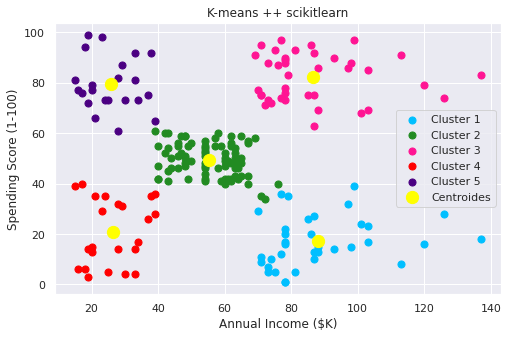

In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

# Visualización
plt.figure(figsize=(8,5))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'deepskyblue', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'forestgreen', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'deeppink', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 50, c = 'red', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 50, c = 'indigo', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 150, c = 'yellow', label = 'Centroides')
plt.title('K-means ++ scikitlearn')
plt.xlabel('Annual Income ($K)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# Inicialización K-means ++ vs K-means

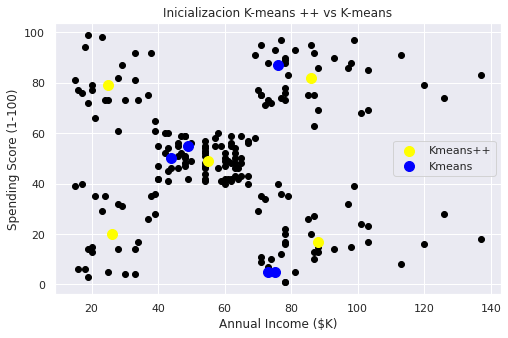

In [ ]:
# Inicializacion random: K-means------------------------------------------------
Centroids_rand=np.array([]).reshape(2,0)
for i in range(K):
    rand=random.randint(0,X.shape[0]-1)
    Centroids_rand=np.c_[Centroids_rand,X[rand]]
# ------------------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1], color='black')
plt.scatter(Centroides[:,0], Centroides[:,1], s=100,color='yellow', marker='o', label='Kmeans++')
plt.scatter(Centroids_rand[0,:],Centroids_rand[1,:], s=100, marker='o', color='blue', label='Kmeans')
plt.title('Inicializacion K-means ++ vs K-means')
plt.xlabel('Annual Income ($K)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# K-means ++ supervisado


In [ ]:
# Division Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Dimensión de X_train:", X_train.shape)
print("Dimensión de X_test:", X_test.shape)
print("Dimensión de y_train:", y_train.shape)
print("Dimensión de y_test:", y_test.shape)

Dimensión de X_train: (160, 2)
Dimensión de X_test: (40, 2)
Dimensión de y_train: (160, 1)
Dimensión de y_test: (40, 1)


## Training

In [ ]:
kmeans = Kmeans_pp(X_train,K)
kmeans.fit(max_iter)
Output, Centroides = kmeans.predict()

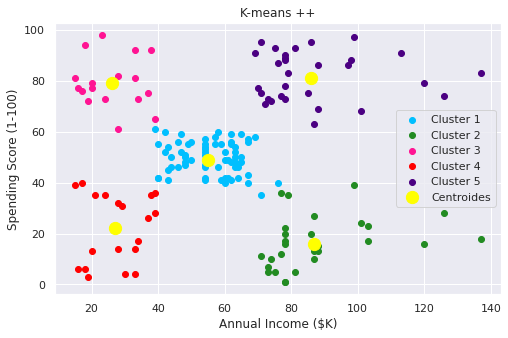

In [ ]:
Visualizacion(Output, Centroides)

## Testing

In [ ]:
def testing(Centroides, X_test, y_test, verbose=False):
    y_test = y_test.ravel()
    # -------------  Calculo de la distancia Euclidiana entre puntos -------------
    y_pred = []
    for i in range(len(X_test)):
      d = np.sum((X_test[i]-Centroides)**2, axis=1)
      y_pred.append(np.argmin(d)+1) 
    # --------------------- Asginacion correcta del cluster ----------------------
      classes_dict, acc = get_accuracy(y_test, y_pred)
      classes_dict[5] = classes_dict.pop(0)
      y_pred_=[classes_dict[_] for _ in y_pred]
    # ------------------------- Matriz de Confusion ------------------------------
      cm = confusion_matrix(y_test, np.array(y_pred_))
      cm = pd.DataFrame(cm)
    # ------------------------------ Reporte -------------------------------------
      report = classification_report(y_test, np.array(y_pred_), output_dict=True)
      precision =  report['macro avg']['precision'] 
      recall = report['macro avg']['recall']    
      accuracy = report['accuracy']
      f1 = report['macro avg']['f1-score']
      f2 = fbeta_score(y_test, np.array(y_pred_), average='macro', beta=0.5)
  # -------------------------- Visualizacion -----------------------------------
    if verbose:
        aux = {}
        for i in np.unique(y_pred_):
            aux[i] = X_test[y_pred_==i]
        Visualizacion(aux, Centroides)
        plt.figure(figsize = (8,5))
        sns.heatmap(cm, annot=True, fmt='g', annot_kws={'size':12}, cmap="Blues")
        plt.title('Matriz de confusión')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
        print(classification_report(y_test, np.array(y_pred_)))
        print('F2-Score: ', round(f2,2))
  # ----------------------------------------------------------------------------
    return precision,recall,accuracy,f1,f2

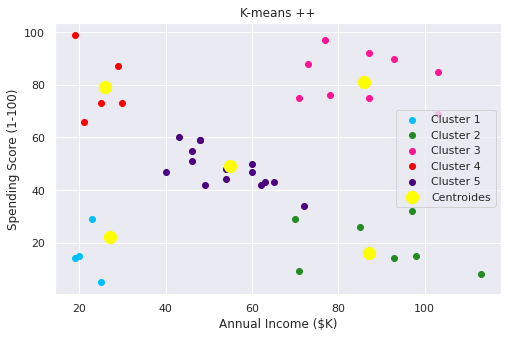

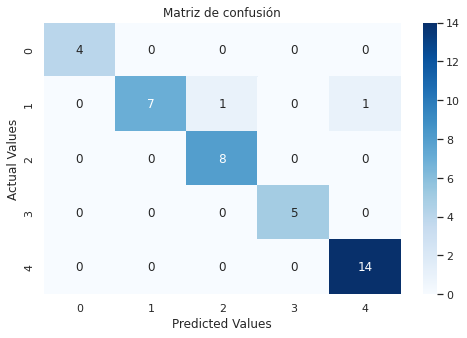

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      0.78      0.88         9
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         5
           5       0.93      1.00      0.97        14

    accuracy                           0.95        40
   macro avg       0.96      0.96      0.96        40
weighted avg       0.95      0.95      0.95        40

F2-Score:  0.96


In [ ]:
precision,recall,accuracy,f1,f2 = testing(Centroides, X_test, y_test, verbose=True)

***

# Experimentos Validación Cruzada

In [ ]:
def kParticiones(particiones, X, y, experimentos=20):
    # Inicializacion de las metricas
    precision = []
    recall = []
    accuracy = []
    f1_score = []
    f2_score = []
    # EXPERIMENTOS ---------------------------------------------------------------
    for e in range(experimentos):
        kf = KFold(n_splits=particiones, shuffle=True)
        p = []
        r = []
        a = [] 
        f1_ = []
        f2_ = []
        # K-PARTICIONES ------------------------------------------------------------
        for train_index, test_index in kf.split(X, y):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            # ---- Training----------------------------------------------------------
            kmeans = Kmeans_pp(X_train,K)
            kmeans.fit(max_iter)
            Output, Centroides = kmeans.predict()
            # ---- Testing ----------------------------------------------------------
            pr,rec,acc,f1,f2 = testing(Centroides, X_test, y_test, verbose=False)
            # ---- Metricas ---------------------------------------------------------
            p.append(pr)
            r.append(rec)
            a.append(acc)
            f1_.append(f1)
            f2_.append(f2)
        # Metricas por experimento -------------------------------------------------
        precision.append(np.mean(p))
        recall.append(np.mean(r))
        accuracy.append(np.mean(a))
        f1_score.append(np.mean(f1_))
        f2_score.append(np.mean(f2_))
        # --------------------------------------------------------------------------
    return precision,recall,accuracy,f1_score,f2_score

## Clases no Balanceadas

### K = 3 / K = 5 / K = 10

In [ ]:
precision_k3,recall_k3,accuracy_k3,f1_score_k3,f2_score_k3 = kParticiones(3, X, y)

In [ ]:
precision_k5,recall_k5,accuracy_k5,f1_score_k5,f2_score_k5 = kParticiones(5, X, y)

In [ ]:
precision_k10,recall_k10,accuracy_k10,f1_score_k10,f2_score_k10 = kParticiones(10, X, y)

### Guardo resultados en un Dataframe

In [ ]:
df_k3 = pd.DataFrame({'precision': precision_k3, 'recall': recall_k3, 'accuracy':accuracy_k3, 
                      'f1_score': f1_score_k3, 'f2_score': f2_score_k3,'k-fold':['k=3']*len(precision_k3)})
df_k5 = pd.DataFrame({'precision': precision_k5, 'recall': recall_k5, 'accuracy':accuracy_k5, 
                      'f1_score': f1_score_k5, 'f2_score': f2_score_k5,'k-fold':['k=5']*len(precision_k5)})
df_k10 = pd.DataFrame({'precision': precision_k10, 'recall': recall_k10, 'accuracy':accuracy_k10, 
                       'f1_score': f1_score_k10, 'f2_score': f2_score_k10,'k-fold':['k=10']*len(precision_k10)})

frames = [df_k3, df_k5, df_k10]
result = pd.concat(frames)
result.index.names = ['Experimentos']
result.reset_index(inplace=True)
result.to_csv('k_results.csv')

## Clases Balanceadas

In [ ]:
def balance_ADASYN(df):
    """ Crea un nuevo DataFrame con clases balanceadas por medio
    del método ADASYN (oversampling).

    :param [df]: Base de Datos
    :type [df]: DataFrame
    ...
    :return: DataFrame con clases balanceadas
    :rtyp
    """
    data = df.copy()
    data.drop(columns=['CustomerID', 'Genre', 'Age'], axis=1, inplace=True)

    X = data.iloc[:,:-1].to_numpy()
    y = data.iloc[:,-1].to_numpy()
    
    counter = collections.Counter(y)
    print('Antes de ADASYN\n Clases: {}\n'.format(counter))
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.legend()
    plt.show()
    
    oversample = ADASYN()
    X, y = oversample.fit_resample(X, y)
    
    data_ADASYN = round(pd.DataFrame(X, columns = data.columns[:-1]), 1)
    data_ADASYN[data.columns[-1]] = pd.DataFrame(y)
    
    counter = collections.Counter(y)
    print('Después de ADASYN\n Clases: {}\n'.format(counter))
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.legend()
    plt.show()
    
    return data_ADASYN

In [ ]:
df

Antes de ADASYN
 Clases: Counter({5: 79, 2: 42, 3: 35, 1: 22, 4: 22})



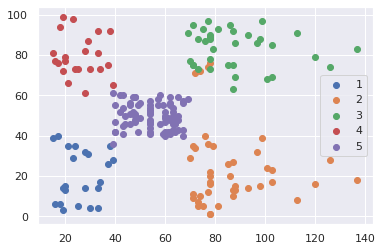

Después de ADASYN
 Clases: Counter({1: 80, 2: 80, 4: 79, 5: 79, 3: 77})



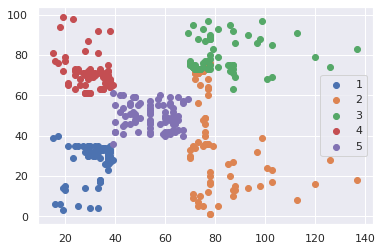

In [ ]:
df_balance = balance_ADASYN(df)

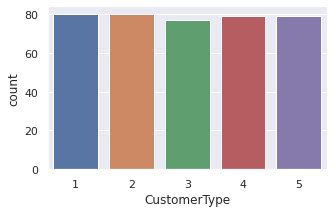

In [ ]:
# Balance de las clases
plt.figure(figsize=(5,3))
g = sns.countplot(x=df_balance['CustomerType'])
plt.show()

In [ ]:
X = df_balance.iloc[:, :-1].values
y = df_balance.iloc[:,-1:].values
print('Num de datos: ', X.shape[0])
print('Num de columnas: ', X.shape[1])

Num de datos:  395
Num de columnas:  2


### K = 3 / K = 5 / K = 10

In [ ]:
precision_k3,recall_k3,accuracy_k3,f1_score_k3,f2_score_k3 = kParticiones(3, X, y)

In [ ]:
precision_k5,recall_k5,accuracy_k5,f1_score_k5,f2_score_k5 = kParticiones(5, X, y)

In [ ]:
precision_k10,recall_k10,accuracy_k10,f1_score_k10,f2_score_k10 = kParticiones(10, X, y)

### Guardo resultados en un Dataframe

In [ ]:
df_k3 = pd.DataFrame({'precision': precision_k3, 'recall': recall_k3, 'accuracy':accuracy_k3, 
                      'f1_score': f1_score_k3, 'f2_score': f2_score_k3,'k-fold':['k=3']*len(precision_k3)})
df_k5 = pd.DataFrame({'precision': precision_k5, 'recall': recall_k5, 'accuracy':accuracy_k5, 
                      'f1_score': f1_score_k5, 'f2_score': f2_score_k5,'k-fold':['k=5']*len(precision_k5)})
df_k10 = pd.DataFrame({'precision': precision_k10, 'recall': recall_k10, 'accuracy':accuracy_k10, 
                       'f1_score': f1_score_k10, 'f2_score': f2_score_k10,'k-fold':['k=10']*len(precision_k10)})

frames = [df_k3, df_k5, df_k10]
result_B = pd.concat(frames)
result_B.index.names = ['Experimentos']
result_B.reset_index(inplace=True)
result_B.to_csv('k_results_B.csv')

### Uno los dataframes

In [ ]:
result_B.loc[:,'Balance'] = 'Si'
result.loc[:,'Balance'] = 'No'

R = pd.concat([result_B, result])
R.to_csv('Resultados_Experimentos.csv')

# Evaluación de Resultados

In [ ]:
metricas = ['precision', 'recall', 'accuracy', 'f1_score', 'f2_score']

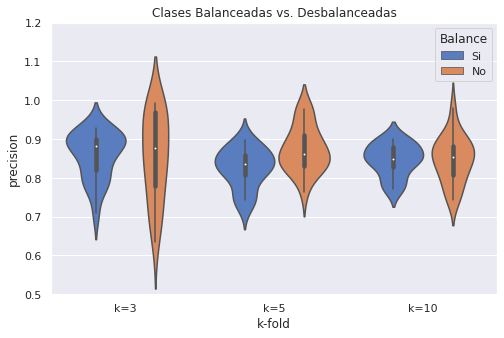

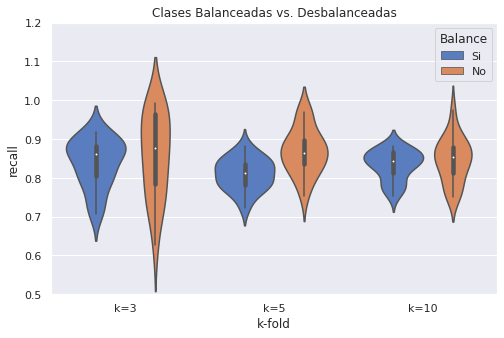

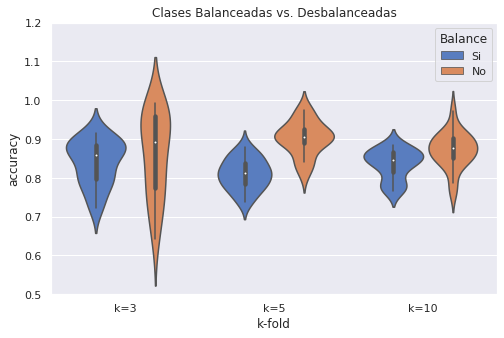

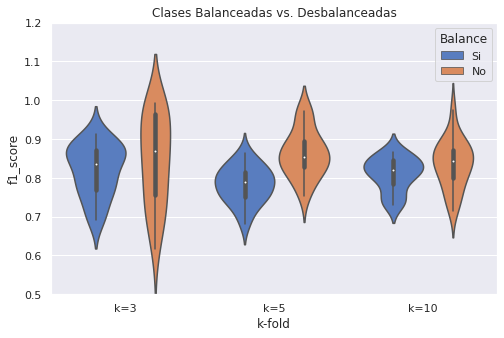

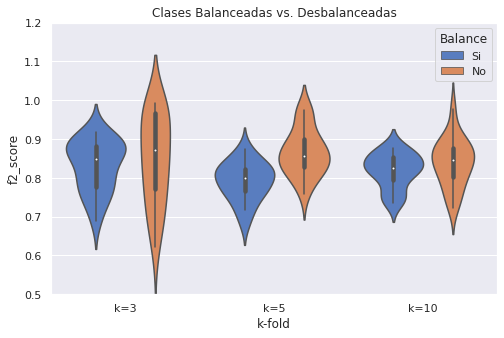

In [ ]:
for m in metricas:
    plt.figure(figsize = (8,5))
    plt.ylim(0.5, 1.2)
    ax = sns.violinplot(x="k-fold", y=m, hue="Balance", data=R, palette="muted")
    ax.set_title("Clases Balanceadas vs. Desbalanceadas")

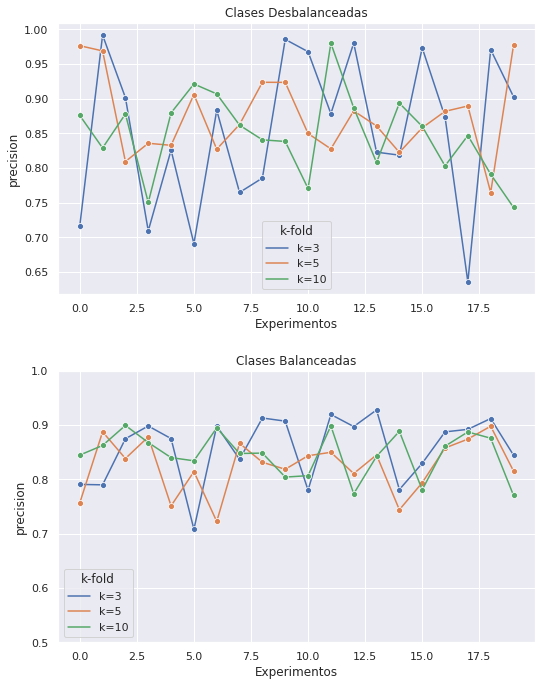

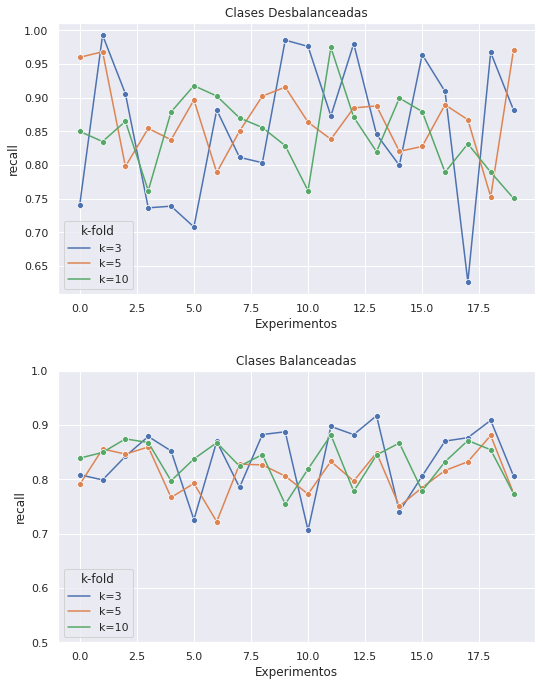

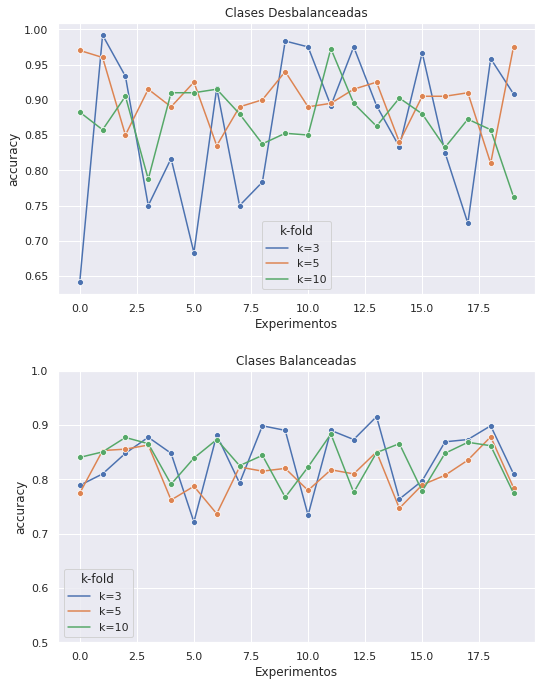

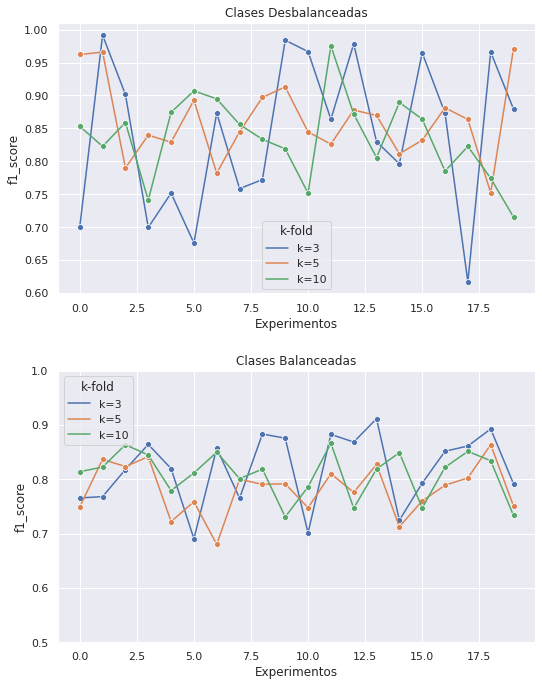

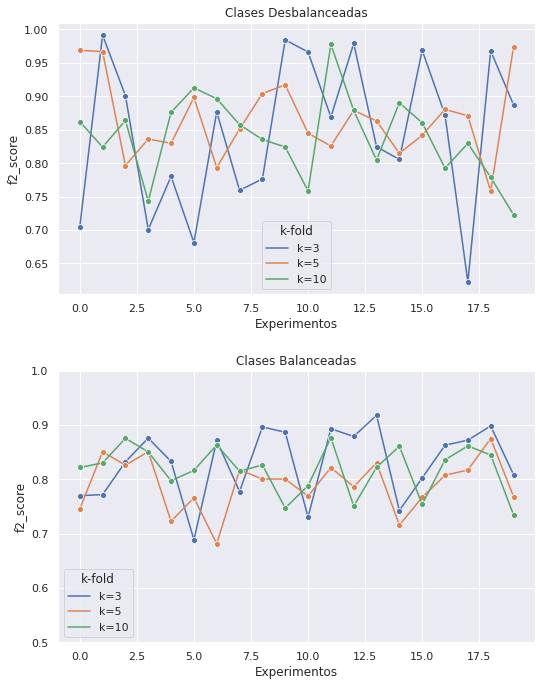

In [ ]:
for m in metricas:
    fig, ax = plt.subplots(2, figsize = (8,10))
    plt.ylim(0.5, 1)

    sns.set_theme(style="darkgrid")
    g1 = sns.lineplot(x="Experimentos", y=m, hue="k-fold", data=result, marker='o', ax=ax[0])
    ax[0].set_title("Clases Desbalanceadas")
    ax[1].set_title("Clases Balanceadas")
    g2 = sns.lineplot(x="Experimentos", y=m, hue="k-fold", data=result_B, marker='o', ax=ax[1])
    fig.tight_layout(pad=2.0)

In [ ]:
print('----------------------------------------------------')
print('E V A L U A C I Ó N   DE  E X P E R I M E N T O S')
print('----------------------------------------------------')
df1 = result.iloc[:,1:6]
df2 = result_B.iloc[:,1:6]
print('MEDIA')
print('----------------------------------------------------')
df_p = df1.mean().to_frame(name='Desbalanceados')
df_p['Balanceados'] = df2.mean().to_frame()
print(df_p)
print('----------------------------------------------------')
print('VARIANZA')
print('----------------------------------------------------')
df_v = df1.var().to_frame(name='Desbalanceados')
df_v['Balanceados'] = df2.var().to_frame()
print(df_v)
print('----------------------------------------------------')
print('DESVIACIÓN ESTÁNDAR')
print('----------------------------------------------------')
df_std = df1.std().to_frame(name='Desbalanceados')
df_std['Balanceados'] = df2.std().to_frame()
print(df_std)

----------------------------------------------------
E V A L U A C I Ó N   DE  E X P E R I M E N T O S
----------------------------------------------------
MEDIA
----------------------------------------------------
           Desbalanceados  Balanceados
precision        0.858631     0.843237
recall           0.856995     0.826578
accuracy         0.877833     0.828017
f1_score         0.846769     0.803761
f2_score         0.850370     0.813544
----------------------------------------------------
VARIANZA
----------------------------------------------------
           Desbalanceados  Balanceados
precision        0.006233     0.002718
recall           0.005976     0.002393
accuracy         0.005427     0.002212
f1_score         0.006881     0.002968
f2_score         0.006674     0.003073
----------------------------------------------------
DESVIACIÓN ESTÁNDAR
----------------------------------------------------
           Desbalanceados  Balanceados
precision        0.078952     0.05213

# Prueba Mann-Whitney U

In [ ]:
def Mann_Whitney_U(df1, df2, alpha = 0.05):
    """ Compara el dataframe original vs. el dataframe con datos sintéticos.
    Aplica la prueba Mann-Whitney U para obtener el p-value y determinar si
    las distribuciones son iguales o no.

    :param [df1]: Base de Datos original
    :type [df1]: DataFrame
    ...
    :param [df1]: Base de Datos con datos sintéticos
    :type [df1]: DataFrame
    ...
    :return: Distribución de cada uno de los atributos (originales vs sinteticos)
    + Desviación Estándar (originales vs. sinteticos)
    :rtype: plot de distribucion y dataframe con las desviaciones estándar
    """
    df1 = df1.iloc[:,1:6]
    df2 = df2.iloc[:,1:6]
    #---------------Distribuciones-------------
    sns.set(rc={"figure.figsize": (5, 3)})
    for column in df1:
        print('------------------------------------')
        print('Análisis de {}'.format(column))
    #--------------------Prueba Mann-Whitney U-----------
        stats, p = mannwhitneyu(df1[column], df2[column]) 
        print('p-value = {}'.format(p)) # Valor p
        if p > alpha:
            print('Misma Distribución (No rechaza H0)')
            print('------------------------------------')
        else:
            print('Diferente Distribución (Rechaza H0)')
            print('------------------------------------')
    #------------------------------Plotting---------------
        df1[column].plot.kde()
        df2[column].plot.kde()
        plt.title('Distribución de {}'.format(column))
        plt.show()

------------------------------------
Análisis de precision
p-value = 0.12901036058107673
Misma Distribución (No rechaza H0)
------------------------------------


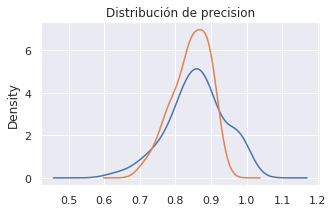

------------------------------------
Análisis de recall
p-value = 0.005096552495554119
Diferente Distribución (Rechaza H0)
------------------------------------


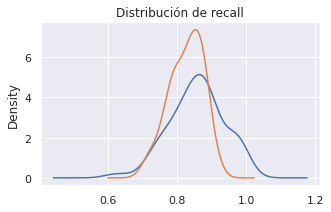

------------------------------------
Análisis de accuracy
p-value = 1.0293495302485044e-06
Diferente Distribución (Rechaza H0)
------------------------------------


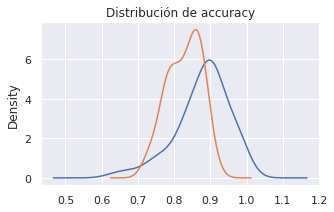

------------------------------------
Análisis de f1_score
p-value = 0.0004022296588519419
Diferente Distribución (Rechaza H0)
------------------------------------


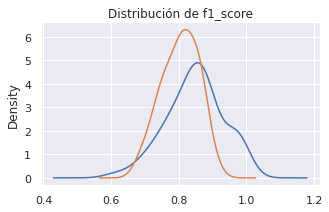

------------------------------------
Análisis de f2_score
p-value = 0.0020973757274792607
Diferente Distribución (Rechaza H0)
------------------------------------


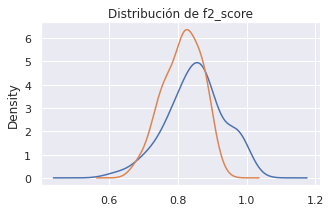

In [ ]:
Mann_Whitney_U(result, result_B)